In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math as m 
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
from scipy.stats import norm
pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")

# HW 1 TOPICS IN ECONOMICS - GROUP 2

<span style="color:blue">Aman Krishna </span> <br>
<br>
<span style="color:#406A5F">Tim Taylor </span> <br>
<br>
<span style="color:purple">Yazmin Ramirez Delgado </span>

## 1 Measuring Hawkish/Dovish Tone of FOMC Statements (100 points)

### 1. 

Scrape the text of the FOMC statements from January 2000 to present. You will need to use https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm for 2018-2023 and https://www.federalreserve.gov/monetarypolicy/fomc_historical_year.htm for 2000-2017. See Appendix A for hints on scraping.

In [138]:
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [139]:
# Constants
DOMAIN = 'https://www.federalreserve.gov'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Linux; Android 5.1.1; SM-G928X Build/LMY47X) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.83 Mobile Safari/537.36',
    "Accept-Encoding": "gzip, deflate",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "DNT": "1", "Connection": "close",
    "Upgrade-Insecure-Requests": "1"
}
PUNC = set(["'", ".", ",", "?", "(", ")", "%", "$", "#", "!"])


def gen_soup_bs4(url):
    '''takes a url and returns a soup object'''
    response = requests.get(url, headers=HEADERS)
    assert response.status_code == 200
    return BeautifulSoup(response.text, "html.parser")

In [140]:
def generate_absolute_url(relative_url):
    return DOMAIN + relative_url

# Get all URLs pre 2016
seed_url = 'https://www.federalreserve.gov/monetarypolicy/fomchistorical{}.htm'
pre2017 = [seed_url.format(n) for n in range(2000, 2018)]

# Get all pre2016 statements URL
pre2017_statements_url = []
for url in pre2017:
    soup = gen_soup_bs4(url)
    for i in soup.find_all('a', {'href': re.compile(r'\/\w+\/press\w*\/')}):
        if i.text.lower() == 'statement':
            statement_url = generate_absolute_url(i['href'])
            pre2017_statements_url.append(statement_url)

In [141]:
# Get URLs for statements after 2017
seed_url_2018 = 'https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm'
soup_post2018 = gen_soup_bs4(seed_url_2018)

post2018_statements_url = []
for i in soup_post2018.find_all('a', {'href': re.compile(r'\/newsevents\/pressreleases\/')}):
    if i.text.lower() == 'html': #just get the statements
        statement_url = generate_absolute_url(i['href'])
        post2018_statements_url.append(statement_url)


In [142]:
post2018_statements_url

['https://www.federalreserve.gov/newsevents/pressreleases/monetary20230201a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230322a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230503a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230614a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230726a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20230920a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220316a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220504a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220615a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220727a.htm',
 'https://www.federalreserve.gov/newsevents/pressreleases/monetary20220921a.htm',
 'https://www.fe

In [143]:
# Federal reserve website structure change after 2006. So, need to scrap separately
all_urls = pre2017_statements_url + post2018_statements_url

# Scrape the text of statements
cols = ['date', 'full_text']
statements = pd.DataFrame(columns=cols) # Declare an empty dataframe

for url in all_urls:
    print(url)
    statement_soup = gen_soup_bs4(url)
    date = re.findall(r'\d{5,}', url)[0] # Get date of the statement 
    year = int(date[:4]) # Year of statement
    
    # Federal reserve changed their website after 2005. Need to cater differently
    if year < 2006:
        try: 
            txt = statement_soup.find_all('tr')[1].text 
        except:
            txt = statement_soup.find_all('tr')[0].text
    else:
        txt = statement_soup.find('div', attrs={'class': 'col-xs-12 col-sm-8 col-md-8'}).text
    
    # Remove unnecessary text
    for pattern in ['(\\n|\\t|\\r)', 'Voting .* policy .* were.*',
                   '(For immediate release|For release at .* E*T)', 
                   'Frequently Asked Questions.*',
                   '[\w\s]+other central banks is available at the following websites:.*']:
        txt = re.sub(pattern, '', txt)
    
    statements = statements.append({'date': date, 'full_text': txt}, ignore_index=True)

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', 500)

https://www.federalreserve.gov/boarddocs/press/general/2000/20000202/
https://www.federalreserve.gov/boarddocs/press/general/2000/20000321/
https://www.federalreserve.gov/boarddocs/press/general/2000/20000516/
https://www.federalreserve.gov/boarddocs/press/general/2000/20000628/
https://www.federalreserve.gov/boarddocs/press/general/2000/20000822/
https://www.federalreserve.gov/boarddocs/press/general/2000/20001003/
https://www.federalreserve.gov/boarddocs/press/general/2000/20001115/
https://www.federalreserve.gov/boarddocs/press/general/2000/20001219/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010103/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010131/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010320/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010418/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010515/
https://www.federalreserve.gov/boarddocs/press/general/2001/20010627/
https://www.federalr

In [144]:
# Save as a csv
statements.to_csv('statements.csv', index=False)

(a) How many statements do you obtain?

In [145]:
print('We get {} statements'.format(len(statements)))

We get 202 statements


(b) Provide summary statistics (mean, standard deviation, minimum, first quartile, median, third quartile, maximum) for the number of words in each statement.

In [146]:
# Calculate the number of words for each statement.
statements['word_count'] = statements['full_text'].apply(lambda x: len(x.split()))

# Display summary statistics.
summary_stats = statements['word_count'].describe()
print(summary_stats)


count    202.00000
mean     329.62376
std      168.76044
min       77.00000
25%      179.25000
50%      292.00000
75%      446.25000
max      798.00000
Name: word_count, dtype: float64


In [147]:
#Change the date column to datetime format
statements['date'] = pd.to_datetime(statements['date'], format='%Y%m%d')
#Sort the dataframe by date
statements = statements.sort_values(by='date')
#Set the index to be the date
statements = statements.set_index('date')

### 2.

Use the methodology described in section 3.1 (pages 4-8) of Tadle (2022) to measure the tone of each speech.2 Download the Fed Funds Effective Rate from https://fred.stlouisfed.org/series/DFF. Plot both the statement tone and the Fed Funds Effective Rate over time.

In [148]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amankrishna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [149]:
df_keywords = pd.read_excel('Tadle2022_keywords.xlsx')
df_funds = pd.read_csv('DFF.csv')

In [150]:
import string

def tokenize_and_clean(statement):
    sentences = sent_tokenize(statement)
    sentences = [sentence.translate(str.maketrans('', '', string.punctuation)).lower() for sentence in sentences]
    return sentences

def contains_keywords(sentence, keywords):
    sentence = str(sentence)
    keywords = [str(keyword) for keyword in keywords]
    return any(keyword in sentence for keyword in keywords)


def score_sentence(sentence, df_keywords):
    pos_keys = set(df_keywords['positive'])
    neg_keys = set(df_keywords['negative'])
    negations = set(df_keywords['negation'])
    hawkish = set(str(keyword) for keyword in df_keywords['hawkish'])  # Convert to string
    dovish = set(str(keyword) for keyword in df_keywords['dovish'])    # Convert to string
    
    tokens = nltk.word_tokenize(sentence)
    
    p = 0
    n = 0
    
    for idx, token in enumerate(tokens):
        if token in pos_keys:
            if any(tok in tokens[max(idx-3,0):idx] for tok in negations):
                n += 1
            else:
                p += 1
        elif token in neg_keys:
            if any(tok in tokens[max(idx-3,0):idx] for tok in negations):
                p += 1
            else:
                n += 1
                
    if (p > n and any(word in sentence for word in hawkish)) or (p < n and not any(word in sentence for word in dovish)):
        return 1
    elif (p > n and any(word in sentence for word in dovish)) or (p < n and any(word in sentence for word in hawkish)):
        return -1
    else:
        return 0
    

In [151]:
statements['sentences'] = statements['full_text'].apply(tokenize_and_clean)
filtered_sentences = statements['sentences'].apply(lambda sentences: [s for s in sentences if contains_keywords(s, df_keywords['hawkish']) or contains_keywords(s, df_keywords['dovish'])])
statements['scores'] = filtered_sentences.apply(lambda sentences: [score_sentence(s, df_keywords) for s in sentences])
statements['index'] = statements['scores'].apply(lambda scores: 100 * np.mean(scores) if len(scores) > 0 else 0)

In [152]:
df_funds.set_index('DATE', inplace=True)
df_funds.index = pd.to_datetime(df_funds.index)

In [153]:
for date in statements.index:
    statements.loc[date, 'fed_rate'] = df_funds.loc[date, 'DFF']

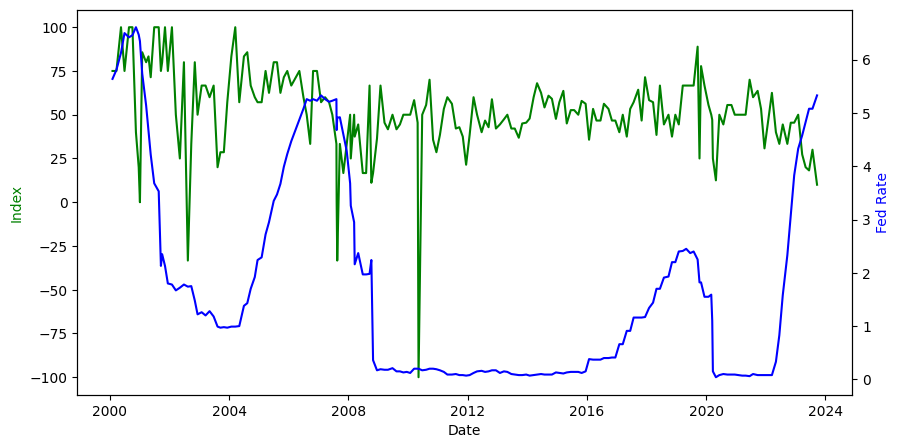

In [154]:
#Plot the column "index" and "fed_rate" against the date on two different y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(statements.index, statements['index'], 'g-')
ax2.plot(statements.index, statements['fed_rate'], 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('Index', color='g')
ax2.set_ylabel('Fed Rate', color='b')
plt.show()


### 3.

Comment on the Tadle (2022) methodology. What do you like about it? What are its shortcomings?

#### Here are some of the things we like about Tadle's methodology:
<span style="color:blue">
- It is systematic and objective, which helps to reduce the potential for bias. <br>
<br>
- It is able to capture the nuances of the language used in the FOMC documents, which is important for understanding the true meaning of the text. <br>
<br>
- It is able to generate continuous sentiment indices, which allows for more precise analysis.<br>
<br> </span>

#### Here are some of the shortcomings of Tadle's methodology:
<span style="color:purple">
- It is based on the assumption that the sentiments expressed in the FOMC documents are accurately reflected in the financial markets. This assumption may not always be true, as there are other factors that can influence market movements. <br>
<br>
- The methodology is only able to capture the sentiments expressed in the FOMC documents, and it does not take into account other factors that may be relevant for predicting financial market changes. <br>
<br>
- The methodology is relatively new, and it has not yet been widely tested.
</span>

### 4.

Describe and implement a different way to measure hawkish/dovish tone of FOMC statements. How does your alternative measure address some of the shortcomings in the Tadle (2022) method? What is the correlation between the Tadle (2022) measure and your measure?

### Source: https://www.turing.com/kb/guide-on-word-embeddings-in-nlp

<span style="color:purple">We use **Vector-based Semantic Analysis using Word Embeddings**<br>
<br>Instead of relying solely on keyword detection, we can leverage word embeddings, specifically the pre-trained embeddings like Word2Vec or FastText, to capture the semantic meaning of the text. This method works on the premise that the meaning of words can be derived from their context in large amounts of text.<br></span>
<span style="color:purple"><br> **Steps**:<br><br>
<span style="color:purple">1. Preprocess the Text:

<span style="color:purple">> Tokenize the statements into sentences and then into words.
Remove stopwords, punctuation, and other non-essential words.
Convert all words to lowercase.

<span style="color:purple">2. Generate Sentence Embeddings:

<span style="color:purple">>For each sentence in a statement, obtain word embeddings for each word in the sentence.
Average the word embeddings in the sentence to obtain a single vector that represents the sentence.

<span style="color:purple">3. Calculate Similarity with Hawkish/Dovish Prototypes:

<span style="color:purple">>Define prototype sentences for both hawkish and dovish tones.
Compute the cosine similarity between each sentence vector in the statement and the prototype vectors.

<span style="color:purple">4. Scoring:

<span style="color:purple">>Assign scores based on similarity values. The more similar a sentence is to the hawkish prototype, the more hawkish it's scored and vice versa for dovish. <br>
<span style="color:purple">>Aggregate the scores to obtain an overall tone for the statement.

<span style="color:purple">5. Implementation:

<span style="color:purple">>For simplicity, we'll use the Gensim library's Word2Vec embeddings. Note: We use Google's pretrained Word2Vec model.
</span>

<span style="color:blue"> **Advantages Over Tadle (2022)**:

<span style="color:blue"> 1. Context Sensitivity: Word embeddings capture semantic meanings, making this method sensitive to context.<br>
<span style="color:blue">2. No Explicit Keyword Dependence: It doesn't rely on predefined lists, which might miss terms or become outdated.<br>
<span style="color:blue">3. Handles Nuanced Sentiments: Can capture subtler tones that might not be explicit hawkish or dovish.<br>
<br>
<span style="color:blue">**Potential Shortcomings**:

<span style="color:blue">1. Complexity: It's more computationally intensive than a simple keyword-based approach.<br>
<span style="color:blue">2. Requires Pre-trained Models: Quality of embeddings and results depend on the quality and relevance of the pretrained models.

In [155]:
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity

In [156]:
# Load Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Define prototype vectors
hawkish_prototype = word2vec_model["hawkish"]  # or average of multiple hawkish words/sentences
dovish_prototype = word2vec_model["dovish"]  # similarly for dovish

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [159]:
def get_sentence_vector(sentence, model):
    words = nltk.word_tokenize(sentence)
    valid_words = [word for word in words if word in model.key_to_index]  # Use key_to_index
    if valid_words:
        vectors = [model.get_vector(word) for word in valid_words]  # Use get_vector
        return np.mean(vectors, axis=0)  # Calculate the mean of word vectors
    else:
        return None


def get_similarity_score(sentence_vector, prototype_vector):
    return cosine_similarity([sentence_vector], [prototype_vector])[0][0]

def get_statement_score(statement, model):
    sentences = nltk.sent_tokenize(statement)
    hawkish_scores, dovish_scores = [], []
    
    for sentence in sentences:
        sentence_vector = get_sentence_vector(sentence, model)
        if sentence_vector is not None:
            hawkish_scores.append(get_similarity_score(sentence_vector, hawkish_prototype))
            dovish_scores.append(get_similarity_score(sentence_vector, dovish_prototype))
    
    # Aggregate scores as needed; here we simply subtract to get a net tone
    return sum(hawkish_scores) - sum(dovish_scores)

In [160]:
# Apply the score on your dataset
statements['new_score'] = statements['full_text'].apply(lambda x: get_statement_score(x, word2vec_model))

In [163]:
correlation_coefficient = statements[['index', 'new_score']].corr().iloc[0, 1]

In [169]:
print('Correlation coefficient between the Taddle Score and the new score is {:.4f}'.format(correlation_coefficient))

Correlation coefficient between the Taddle Score and the new score is -0.2016


### 5.

Redo the plot from problem 2, adding your tone measure. Your plot should include the Tadle (2022) measure, your measure and the Fed Funds Effective Rate.

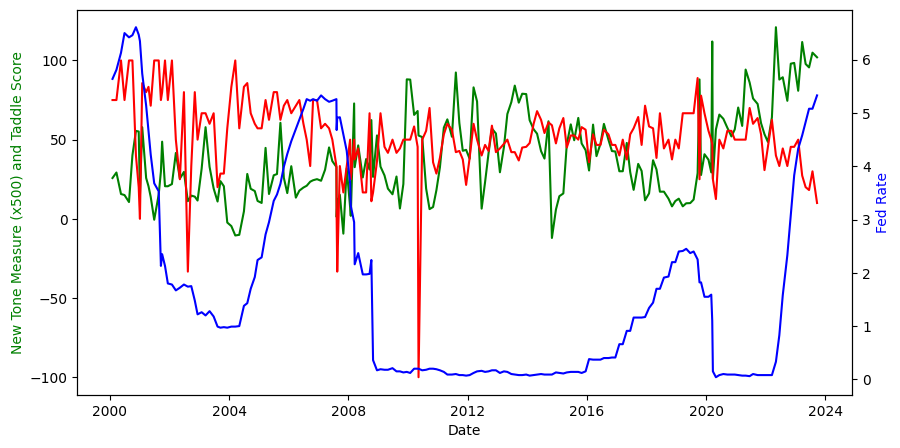

In [173]:
#Plot the column "index" and "fed_rate" against the date on two different y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()
ax1.plot(statements.index, statements['new_score']*500, 'g-')
ax1.plot(statements.index, statements['index'], 'r-')
ax2.plot(statements.index, statements['fed_rate'], 'b-')
ax1.set_xlabel('Date')
ax1.set_ylabel('New Tone Measure (x500) and Taddle Score', color='g')
ax2.set_ylabel('Fed Rate', color='b')
plt.show()

### 6.

Complete this problem twice: once with the Tadle (2022) measure of hawkishness and once with your measure. The steps will guide you through using the Fama and MacBeth (1973) procedure to estimate the monetary policy risk premium in industry returns data. In particular:

(a) Estimate an AR(1) model from the hawkishness data. Compute the residual. We will call this the “text-based monetary policy shock.”

### Hawkishness

In [174]:
from statsmodels.tsa.ar_model import AutoReg

# Fit an AR(1) model
model = AutoReg(statements['index'], lags=1)
model_fit = model.fit()

# Compute the residual
residual_tadle = model_fit.resid

### Word Embedding

In [175]:
# Fit an AR(1) model
model_alt = AutoReg(statements['new_score'], lags=1)
model_fit_alt = model_alt.fit()

# Compute the residual
residual_alt = model_fit_alt.resid

(b) Use the value-weighted returns from the daily industry returns file for this problem. For each of the 49 industries, regress returns on the day of the Fed announcement on the text-based monetary policy shock. Create a table with three columns: column 1 has the industry name, column 2 has the OLS regression coefficient and column 3 has the p-value for that coefficient. Sort the table from largest to smallest coefficient. To be concrete, the regression you are running at this stage is:

$ R_{it} = \alpha_{i} + \beta_{i} \Delta H A W K_{t} + \epsilon_{it} $

for each of the 49 industries, indexed by $i$. Time $t$ here indexes Fed announcement days and $ \Delta H A W K_{t} $ is the text-based monetary policy shock at time $ t $.

In [203]:
industry_df = pd.read_csv('49_Industry_Portfolios_daily.CSV', skiprows=9, nrows=25543, index_col=0)
industry_df.index.name = 'Date'
industry_df.index = pd.to_datetime(industry_df.index, format='%Y%m%d')

In [220]:
#conver the residual series to dataframe
residual_tadle_df = pd.DataFrame(residual_tadle)
residual_alt_df = pd.DataFrame(residual_alt)

#Rename the residual column
residual_tadle_df.columns = ['residual_tadle']
residual_alt_df.columns = ['residual_alt']

#merge the industry with the residual alt and tadle
industry_df_tadle = pd.merge(industry_df, residual_tadle_df, how='inner', left_index=True, right_index=True)
industry_df_alt = pd.merge(industry_df, residual_alt_df, how='inner', left_index=True, right_index=True)

In [222]:
#For each of the 49 industries, regress returns to the residual series (tadle and alt)
#Create a table with three columns: column 1 has the industry name, column 2 has the OLS regression coefficient and column 3 has the p-value for that coefficient.

table_tadle = pd.DataFrame(columns=['Industry', 'Coefficient', 'p-value'])
table_alt = pd.DataFrame(columns=['Industry', 'Coefficient', 'p-value'])

for i in range(0,49):
    industry = industry_df_tadle.columns[i]
    x = industry_df_tadle['residual_tadle']
    y = industry_df_tadle[industry]
    model = sm.OLS(y, x, missing='drop')
    results = model.fit()
    table_tadle = table_tadle.append({'Industry': industry, 'Coefficient': results.params[0], 'p-value': results.pvalues[0]}, ignore_index=True)
    
for i in range(0,49):
    industry = industry_df_alt.columns[i]
    x = industry_df_alt['residual_alt']
    y = industry_df_alt[industry]
    model = sm.OLS(y, x, missing='drop')
    results = model.fit()
    table_alt = table_alt.append({'Industry': industry, 'Coefficient': results.params[0], 'p-value': results.pvalues[0]}, ignore_index=True)
    
table_tadle = table_tadle.set_index('Industry')
table_alt = table_alt.set_index('Industry')

### Hawkishness

In [224]:
#Sort the table from largest to smallest coefficient
table_tadle = table_tadle.sort_values(by='Coefficient', ascending=False)
table_tadle

,Coefficient,p-value
Industry,,
Aero,0.01364,0.09221
Drugs,0.00920,0.03325
Guns,0.00684,0.27278
Insur,0.00540,0.41695
Ships,0.00427,0.53067
Cnstr,0.00406,0.63027
Util,0.00278,0.56260
Meals,0.00268,0.63898
Hshld,0.00229,0.59134


### Word Embedding

In [226]:
table_alt.to_clipboard()

In [225]:
table_alt = table_alt.sort_values(by='Coefficient', ascending=False)
table_alt

,Coefficient,p-value
Industry,,
Oil,12.00883,0.00030
Coal,11.20219,0.04819
Mines,10.06611,0.01776
Agric,9.87561,0.00418
Chems,9.08468,0.00502
Cnstr,8.79824,0.03328
Ships,8.45891,0.01108
Banks,7.33079,0.09305
BldMt,7.06099,0.02774


(c) Comment on the ordering of the industries. Is it in line with what you would have expected?

(d) Now turn to the monthly returns data. Again use the value-weighted returns. Separately for each month, regress returns of each industry on its “beta” from step (b). To be concrete, for each month, indexed by $T$, you are running the following regression:

$ R_{i,T} = \gamma_{T} + \lambda_{T} \beta_{i} + \eta_{iT} $

(e) What is the average $\lambda$ across all months? This is the risk premium associated with holding assets exposed to
monetary policy risk. Comment on how its sign can be interpreted.

(f) What is the standard deviation of $\lambda$? Use this to compute the $t-statistic$. Is the risk premium significantly different from zero at the 10%, 5% or 1% level?

## Reading Response (15 points)

### Optional for extra credit. Must be completed individually.

Read Aruoba and Drechsel (2022) and answer the following questions.

1. Describe the natural language processing technique that the authors use. What do you like about it? What are its shortcomings?

2. Summarize (in your own words) the findings discussed in Section 4.

3. What questions do you have after reading the paper?